# Generate Simulations

100%|██████████| 162/162 [00:01<00:00, 81.56it/s] 


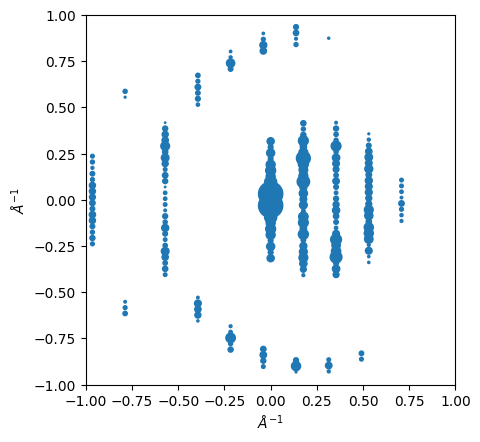

In [1]:
from orix.crystal_map import Phase
from orix.sampling import get_sample_reduced_fundamental
from diffsims.generators.simulation_generator import SimulationGenerator
from diffpy.structure import Lattice, Structure
from diffpy.structure.spacegroups import GetSpaceGroup
from parse_pdb_with_scale_remove_h import parse_pdb_with_scale

pdbfile = "/Users/xiaodong/Desktop/simulations/lyso/lyso.pdb"

cell, sg_sym, atoms = parse_pdb_with_scale(pdbfile, remove_hydrogens=True, include_occupancy=False)

resolution = 20                  # angular resolution(granularity) of simulation in degrees
reciprocal_radius = 1/1       # 1/Å (i.e. Å⁻¹)
with_direct_beam = False        # Include the direct beam
max_excitation_error = 0.001        # approx 1/thickness of crystal
shape_factor_width = None       # None or float if none then set to max_excitation_error
accelerating_voltage = 300      # kV
space_group = GetSpaceGroup(sg_sym)  # Space group symbol (e.g., 'P 1 21/c 1')

# Create the structure and corresponding phase
lattice = Lattice(*cell)
structure = Structure(atoms, lattice)
phase = Phase(space_group = space_group, structure=structure)

# Sample orientations in the symmetry-reduced zone (resolution in degrees)
orientations = get_sample_reduced_fundamental(resolution=resolution, point_group=phase.point_group)

# Initialize the simulation generator (e.g., setting the accelerating voltage)
generator = SimulationGenerator(accelerating_voltage = accelerating_voltage, approximate_precession = False)

# Calculate 2D diffraction simulations using the provided phase and orientations
simulations = generator.calculate_diffraction2d(
    phase = phase,
    rotation = orientations,
    reciprocal_radius = reciprocal_radius,
    with_direct_beam = with_direct_beam,
    max_excitation_error = max_excitation_error,
    shape_factor_width = shape_factor_width,
    debye_waller_factors = None,
    show_progressbar = True
)

simulations.plot();

# Add Simulations to Image with or without Background

In [ ]:
import os
from tqdm import tqdm
import h5py
from cif2cell_gemmi import write_cell
from generate_geom import write_geom_file
from calculate_calibration import calculate_calibration
from create_empty_backgrounds import create_empty_backgrounds
from helper_functions_UB import copy_h5_file, get_next_simulation_folder
from compute_B import compute_B

# params = extract_parameters(pdbfile)

sg = phase.space_group                     # diffpy SpaceGroup
cs = sg.crystal_system.lower()             # "triclinic"
cent = sg.short_name[0].upper()            # "P"
lattice = phase.structure.lattice
cell = (
    lattice.a,
    lattice.b,
    lattice.c,
    lattice.alpha,
    lattice.beta,
    lattice.gamma,
)
params = {
    "lattice_type": cs,
    "centering": cent,
    "a": lattice.a,
    "b": lattice.b,
    "c": lattice.c,
    "alpha": lattice.alpha,
    "beta": lattice.beta,
    "gamma": lattice.gamma,
}
in_plane_angle = 180                # set to correspond to geometry file definitions of xs and ss, if p0/corner_x = -512.5 p0/corner_y = -512.5 set to 180
sigma = 1                           # spread of the  in pixels
wavelength = 0.019687               # wavelength in Å
clen = 1.3                          # camera length in m
pixels_per_m = 17857.14285714286    # pixels per meter (i.e. 1e-6 m/pixel)
calibration = calculate_calibration(
    wavelength_A=wavelength, 
    clen_m=clen, res=pixels_per_m)  # calculated based on geometry (use script to calculate)
fast = False                        # use fast if no subpixel accuracy is needed
normalize = True                    # normalize the intensities of simulated spots
fast_clip_threshold = 1e-12         # threshold for clipping the fast simulation
intensity_scale = 10000             # scale the intensity of the simulated spots

working_dir = os.path.dirname(pdbfile)
create_empty_backgrounds(working_dir, simulations.current_size)
input_filename = os.path.join(working_dir, f"{simulations.current_size}_empty_backgrounds.h5")

# Compute the B matrix from cell parameters
B = compute_B(cell)

# 1. Create a new simulation folder
base_dir = os.path.dirname(input_filename)
new_sim_folder = get_next_simulation_folder(base_dir)

output_cell_base = os.path.basename(pdbfile).replace(".pdb", ".cell")
output_cell = os.path.join(new_sim_folder, output_cell_base)
write_cell(params, output_cell)

output_geom_base = os.path.basename(pdbfile).replace(".pdb", ".geom")
output_geom = os.path.join(new_sim_folder, output_geom_base)
write_geom_file(
    filename=output_geom,
    wavelength=wavelength,
    clen=clen,
    res=pixels_per_m
)
# 2. Copy the original file to the new simulation folder
output_filename = os.path.join(new_sim_folder, "sim.h5")
copy_h5_file(input_filename, output_filename)

# 3. Process the simulation images.
with h5py.File(output_filename, "r+") as data:
    images = data["entry"]["data"]["images"]
    orientation_matrices = data["entry"]["data"].require_dataset(
        "simulation_orientation_matrices", 
        shape=(images.shape[0], 3, 3), 
        dtype=float
    )
    det_shift_x_mm = data["entry"]["data"].require_dataset(
    "det_shift_x_mm",
    shape=(images.shape[0],),
    dtype=float,
    fillvalue=0
    )
    det_shift_y_mm = data["entry"]["data"].require_dataset(
    "det_shift_y_mm",
    shape=(images.shape[0],),
    dtype=float,
    fillvalue=0
    )

    shape = images.shape[-2:]
    beam_pos = (shape[0] // 2, shape[1] // 2)

    for i in tqdm(range(images.shape[0]), desc="Processing images"):
        img = simulations.irot[i].get_diffraction_pattern(
            shape=shape,
            direct_beam_position=beam_pos,
            in_plane_angle=in_plane_angle,  
            sigma=sigma,
            calibration=calibration,
            fast=fast,
            normalize=normalize,
            fast_clip_threshold=fast_clip_threshold
        )
        img = (img * intensity_scale).astype(images.dtype)
        images[i] += img
        orientation_matrices_i = simulations.rotations[i].to_matrix().squeeze()
        
        orientation_matrices[i] = B @ orientation_matrices_i 

print("Processing complete. Updated file saved at:", output_filename)

# Construct the full file path
simulation_parameter_txt = os.path.join(new_sim_folder, "simulation_parameters.txt")

# Write variables and their values to the file
with open(simulation_parameter_txt, "w") as file:
    file.write(f"pdb_file = {pdbfile}\n")
    file.write(f"resolution = {resolution}\n")
    file.write(f"reciprocal_radius = {reciprocal_radius}\n")
    file.write(f"with_direct_beam = {with_direct_beam}\n")
    file.write(f"max_excitation_error = {max_excitation_error}\n")
    file.write(f"shape_factor_width = {shape_factor_width}\n")
    file.write(f"accelerating_voltage = {accelerating_voltage}\n")
    file.write(f"cell = {cell}\n")
    file.write(f"input_filename = {input_filename}\n")
    file.write(f"shape = {shape}\n")
    file.write(f"beam_pos = {beam_pos} (actually 0.5 pixels less i.e use p0/corner_x, p0/corner_y = -{(beam_pos[0] + 0.5, beam_pos[1] + 0.5)} in .geom file)\n")
    file.write(f"sigma = {sigma}\n")
    file.write(f"calibration = {calibration}\n")
    file.write(f"fast = {fast}\n")
    file.write(f"normalize = {normalize}\n")
    file.write(f"fast_clip_threshold = {fast_clip_threshold}\n")
    file.write(f"intensity_scale = {intensity_scale}\n")

print(f"Variables have been written to {simulation_parameter_txt}")

# Read back the entire dataset into memory
with h5py.File(output_filename, "r") as data:
    orientation_matrices_np = data["entry"]["data"]["simulation_orientation_matrices"][:]
output_sol = os.path.join(new_sim_folder, "orientation_matrices.sol")

# First-letter mapping for Bravais lattice symbols
LATTICE_CODE = {
    'triclinic':     'a',
    'monoclinic':    'm',
    'orthorhombic':  'o',
    'tetragonal':    't',
    'rhombohedral':  'h',
    'hexagonal':     'h',
    'cubic':         'c'
}

# Compute Bravais code: lattice letter + centering
lat_code = LATTICE_CODE.get(cs, '?')
bravais = f"{lat_code}{cent}"

# Write orientation matrices to a .sol file
with open(output_sol, "w") as sol_file:
    for i, matrix in enumerate(orientation_matrices_np):
        # Flatten the 3x3 matrix (row-major order)
        # Each number is formatted with a sign (+ or -) and 7 decimal places.
        line = " ".join(f"{num:+.7f}" for num in matrix.flatten())
        sol_file.write(f"{output_filename} //{i} " + line + f" 0.000 0.000 {bravais}\n")

Created dataset 'backgrounds' in file: /Users/xiaodong/Desktop/simulations/lyso/162_empty_backgrounds.h5
Dataset shape:     (162, 1024, 1024)
Data type:         float32
Chunk dimensions:  (162, 1024, 1024)
→ Wrote /Users/xiaodong/Desktop/simulations/lyso/simulation-4/lyso.geom


Processing images: 100%|██████████| 162/162 [00:07<00:00, 22.95it/s]

Processing complete. Updated file saved at: /Users/xiaodong/Desktop/simulations/lyso/simulation-4/sim.h5
Variables have been written to /Users/xiaodong/Desktop/simulations/lyso/simulation-4/simulation_parameters.txt


# Show Simulations on Background from .h5 file

In [ ]:
# To make sure plots display inline
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact
from helper_functions_UB import load_h5_data, view_image

# 4. Load the processed data for interactive visualization
images_arr, orientation_matrices_str = load_h5_data(output_filename)

# 5. Set up the interactive viewer
interact(lambda index: view_image(index, images_arr, orientation_matrices_str), 
         index=widgets.IntSlider(min=0, max=images_arr.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='index', max=270), Output()), _dom_classes=('widget-inter…

<function __main__.<lambda>(index)>

# Integration from .sol file

In [7]:
from gandalf_iterator import gandalf_iterator

geomfile_path = output_geom
cellfile_path = output_cell
input_path =   new_sim_folder
input_sol_file = output_sol

output_file_base = "from_file"

num_threads = 8
x, y = 512.5, 512.5
step_size = 0.5
layers = 0

extra_flags=[
# PEAKFINDING
"--no-revalidate",
"--no-half-pixel-shift",

"--peaks=peakfinder9",
# "--min-snr=1",
# "--min-snr-biggest-pix=1",
# "--min-sig=10",
# "--local-bg-radius=5",

# "--peaks=peakfinder8",
# "--threshold=1",
# "--min-snr=1",
# "--min-pix-count=1",
# "--max-pix-count=500",
# "--local-bg-radius=10",
# "--min-res=1",
# "--max-res=800",

# INDEXING
"--indexing=file",
f"--fromfile-input-file={input_sol_file}",
"--no-check-cell",
"--no-check-peaks",
"--no-retry",
"--no-refine",
# INTEGRATION
"--integration=rings",
"--int-radius=4,5,10",
# OUTPUT
"--no-non-hits-in-stream",
"--fix-profile-radius=70000000",
]

"""Examples of extra flags(see crystfel documentation https://www.desy.de/~twhite/crystfel/manual-indexamajig.html):"""

""" Basic options
"--highres=n",
"--no-image-data",
"""

""" Peakfinding
"--peaks=cxi",
"--peak-radius=inner,middle,outer",
"--min-peaks=n",
"--median-filter=n",
"--filter-noise",
"--no-revalidate",
"--no-half-pixel-shift",

"--peaks=peakfinder9",
"--min-snr=1",
"--min-snr-peak-pix=6",
"--min-snr-biggest-pix=1",
"--min-sig=9",
"--min-peak-over-neighbour=5",
"--local-bg-radius=5",

"--peaks=peakfinder8",
"--threshold=45",
"--min-snr=3",
"--min-pix-count=3",
"--max-pix-count=500",
"--local-bg-radius=9",
"--min-res=30",
"--max-res=500",
"""

""" Indexing
"--indexing=xgandalf",

"--tolerance=tol"
"--no-check-cell",
"--no-check-peaks",
"--multi",
"--no-retry",
"--no-refine",

"--xgandalf-sampling-pitch=n"
"--xgandalf-grad-desc-iterations=n"
"--xgandalf-tolerance=n"
"--xgandalf-no-deviation-from-provided-cell"
"--xgandalf-max-lattice-vector-length=n"
"--xgandalf-min-lattice-vector-length=n"
"--xgandalf-max-peaks=n"
"--xgandalf-fast-execution"
"""

""" Integration
"--integration=rings",
"--int-radius=10,11,15",
"--push-res=n",
"--overpredict",
"--cell-parameters-only",
"""

""" Output
"--no-non-hits-in-stream",
"--no-peaks-in-stream",
"--no-refls-in-stream",
"--serial-offset
"""

gandalf_iterator(x, y, geomfile_path, cellfile_path, input_path, output_file_base, num_threads, step_size, layers, extra_flags=extra_flags)


'list.lst' has been created with 1 entries at /Users/xiaodong/Desktop/simulations/lyso/simulation-4/list.lst


Processing XY pairs:   0%|          | 0/1 [00:00<?, ?it/s]

Running for x=-512.5, y=-512.5


This is what I understood your unit cell to be:
triclinic P, right handed.
a      b      c            alpha   beta  gamma
 26.66  31.15  33.57 A     87.73 108.97 111.60 deg
Read 162 crystals from /Users/xiaodong/Desktop/simulations/lyso/simulation-4/orientation_matrices.sol
List of indexing methods:
   0: file-nolatt-nocell        (file - no prior information)
Indexing parameters:
                  Check unit cell parameters: off
                        Check peak alignment: off
                   Refine indexing solutions: off
 Multi-lattice indexing ("delete and retry"): off
                              Retry indexing: off
105 images processed, 105 hits (100.0%), 105 indexable (100.0% of hits, 100.0% overall), 105 crystals, 20.8 images/sec.
Waiting for the last patterns to be processed...
Worker 4 was killed by signal 6
Event ID was: /Users/xiaodong/Desktop/simulations/lyso/simulation-4/sim.h5 //154 155
Task ID was: read_queue
Worker 5 was killed by signal 6
Event ID was: /Users/xia

Error during indexamajig execution: Command 'indexamajig -g /Users/xiaodong/Desktop/simulations/lyso/simulation-4/lyso.geom -i /Users/xiaodong/Desktop/simulations/lyso/simulation-4/list.lst -o /Users/xiaodong/Desktop/simulations/lyso/simulation-4/from_file_-512.5_-512.5.stream -p /Users/xiaodong/Desktop/simulations/lyso/simulation-4/lyso.cell -j 8 --no-revalidate --no-half-pixel-shift --peaks=peakfinder9 --indexing=file --fromfile-input-file=/Users/xiaodong/Desktop/simulations/lyso/simulation-4/orientation_matrices.sol --no-check-cell --no-check-peaks --no-retry --no-refine --integration=rings --int-radius=4,5,10 --no-non-hits-in-stream --fix-profile-radius=70000000' died with <Signals.SIGABRT: 6>.


# Index using XGANDALF and Integration using rings

In [ ]:
from gandalf_iterator import gandalf_iterator

geomfile_path = "/Users/xiaodong/Desktop/simulations/LTA/LTAsim.geom"
cellfile_path = "/Users/xiaodong/Desktop/simulations/LTA/LTA.cell"
input_path =   "/home/bubl3932/files/LTA_sim/simulation-42"
output_file_base = "LTA"

num_threads = 24
x, y = 512.5, 512.5
step_size = 0.01
layers = 0
extra_flags=[
# PEAKFINDING
"--no-revalidate",
"--no-half-pixel-shift",
"--peaks=peakfinder9",
"--min-snr=1",
"--min-snr-biggest-pix=1",
"--min-sig=3",
"--local-bg-radius=10",
# INDEXING
"--indexing=xgandalf",
# "--tolerance=10,10,10,5",
"--no-refine",
"--xgandalf-sampling-pitch=5",
"--xgandalf-grad-desc-iterations=1",
"--xgandalf-tolerance=0.02",
"--xgandalf-no-deviation-from-provided-cell",
# INTEGRATION
"--integration=rings",
"--int-radius=4,5,9",
"--fix-profile-radius=70000000",
# OUTPUT
"--no-non-hits-in-stream",
]

"""Examples of extra flags(see crystfel documentation https://www.desy.de/~twhite/crystfel/manual-indexamajig.html):"""

""" Basic options
"--highres=n",
"--no-image-data",
"""

""" Peakfinding
"--peaks=cxi",
"--peak-radius=inner,middle,outer",
"--min-peaks=n",
"--median-filter=n",
"--filter-noise",
"--no-revalidate",
"--no-half-pixel-shift",

"--peaks=peakfinder9",
"--min-snr=1",
"--min-snr-peak-pix=6",
"--min-snr-biggest-pix=1",
"--min-sig=9",
"--min-peak-over-neighbour=5",
"--local-bg-radius=5",

"--peaks=peakfinder8",
"--threshold=45",
"--min-snr=3",
"--min-pix-count=3",
"--max-pix-count=500",
"--local-bg-radius=9",
"--min-res=30",
"--max-res=500",
"""

""" Indexing
"--indexing=xgandalf",

"--tolerance=tol"
"--no-check-cell",
"--no-check-peaks",
"--multi",
"--no-retry",
"--no-refine",

"--xgandalf-sampling-pitch=n"
"--xgandalf-grad-desc-iterations=n"
"--xgandalf-tolerance=n"
"--xgandalf-no-deviation-from-provided-cell"
"--xgandalf-max-lattice-vector-length=n"
"--xgandalf-min-lattice-vector-length=n"
"--xgandalf-max-peaks=n"
"--xgandalf-fast-execution"
"""

""" Integration
"--fix-profile-radius=n",
"--fix-divergence=n",
"--integration=rings",
"--int-radius=4,5,10",
"--push-res=n",
"--overpredict",
"--cell-parameters-only",
"""

""" Output
"--no-non-hits-in-stream",
"--no-peaks-in-stream",
"--no-refls-in-stream",
"--serial-offset
"""

gandalf_iterator(x, y, geomfile_path, cellfile_path, input_path, output_file_base, num_threads, step_size, layers, extra_flags=extra_flags)


In [ ]:
import os 
from run_partialator_and_convert import run_partialator_and_convert
from convert_hkl_crystfel_to_shelx import convert_hkl_crystfel_to_shelx

stream_file = "/home/bubl3932/files/LTA_sim/simulation-41/LTAsim_from_file_-512.5_-512.5.stream"
#"/Users/xiaodong/Desktop/simulations/LTA/simulation-43/LTAsim_from_file_-512.5_-512.5.stream" # Stream file to be merged
pointgroup = "m-3m"  # Point group of the crystal
num_threads = 24
iterations = 5

output_dir = run_partialator_and_convert(
    stream_file,
    pointgroup=pointgroup,
    num_threads=num_threads,
    iterations=iterations,
)

if output_dir is not None:
    print("All done. Results are in:", output_dir)

convert_hkl_crystfel_to_shelx(os.path.join(output_dir, "crystfel.hkl"))
